In [1]:
from functions import *
import warnings

warnings.filterwarnings('ignore')

# USER TRANSMITTER 

### Loading the Galileo E1 PRNs
In order to generate the signal, we need first of all to load the pseudo random noise sequences.

There exist two different kinds of PRN codes for Galileo E1: E1B and E1C.
They are contained, in hexadecimal format, in the files called repectively "E1B - Gal.txt" and "E1C - Gal.txt"

For this simulation, we only consider the E1B PRNs:

In [2]:
filename = "E1B - Gal.txt"

# defining the name of the column of the dataframe called e1b
columns = ["Hexadecimal"]

#reading the file
e1b = pd.read_table(filename, sep="\r\n", header=None, names=columns)

e1b.head()

# deleting the first 15 characters (not part of the code)
e1b['Hexadecimal'] = [el[16::] for el in e1b['Hexadecimal']]

# creating a new column with the codes indexes and placing it as first column
e1b['Code index'] = np.arange(1,51,1)
column_list = ["Code index", "Hexadecimal"]
e1b = e1b.reindex(columns=column_list)

# printing the first lines of the dataframe
e1b.head()

ValueError: Length of values (50) does not match length of index (2615)

In [3]:
# last code (just to verify if the loading operation is correct)
print(e1b['Hexadecimal'][49])

97051FC67ACA30E8AEE73D3A8CF38BB13524D4E0EBD9BE68398C7C16227CABB1D0B0A0ABE7B6384ABA02905BA0C3C7363599D059C7B4C99DB165CD14FA12FA7912449CA7DD5E346D8010C85A757382270DAD15BA3CE36A76EF55F81A1E80BF366B37FE3A88EC722028C25E234E624040450A99CD808F942568AA7133981D72E7F2928894670AD5399482DF1B90E7E64062F830B736C79C30F36281495C76699CD48404673FA334F042F9E0E67DD7F3853BF71ABEAF6A9A5546855E840CE42B224D8F6490C6CE5FC02EBAF4FFC390107058F54CD635D4A7F2878099C1EF495750E6921BE2F39AD808C4210F287319F811A254CEF8CF153FC50AB2F3D694A530949E5F578D075DB96DDCF2BB90ED3DE09D9CA8E08662FD8982741DE1CE0A6B64C3D3D5004B5C04B2B0DFD976A20FACC94D1762D41EE03B40D2CF367612812EF4CC41D1BFE9CEB51AE3A22AF1BE7B85A057D3048D0E73FA0FDAF1119EFD76F0A41BE63128B22D64A5553E9549D411483BBCA1483EF30CF6A6D317AD2C7973EFA6D4C1121F703D2F48FCDA3177AD450D75D2A28D2C244AEA13F0E60AEED8ACBAB444D400DF5E280DB799B2D9A984DF1E2567D39D1DE58EF78CA6B4D8BC172B07DCB02D156CA96EEFAC69E556CFCE0AAB617C7FBB8C34871C1D35E74B7BD307D3F2E424C7A9AD676A1A69E0FE735EA50887A1DFAE6CA2

In [4]:
# simple conversion from hexadecimal to binary
def hex2bin(h):
    integer = int(h, 16)
    binary = bin(integer)[2::]     #discarding the first two elements (i.e. 0b, not needed)
    binary = np.array([int(x) for x in binary])    #the binary representation is a numpy array of integers
    return binary
    
# creation of a new column of the dataframe with the binary representation of each PRN
e1b['Binary'] = e1b['Hexadecimal'].apply(hex2bin)

#creation of a copy of the dataframe to use without modifying the original dataframe
e1bcopy = e1b.copy()
e1b

,Code index,Hexadecimal,Binary
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ..."
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...,"[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, ..."
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ..."
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ..."
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, ..."
5,6,90E92279CD4F60D98F6E8FCB3E9263DB60FAB146A835AA...,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, ..."
6,7,A91F570102961D62CA6CB55144AFCCEAF3910F3336DCB0...,"[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, ..."
7,8,C6E00978E351164532EEA256ECBE0D4F8FCE02A276BD19...,"[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, ..."
8,9,821BBB3FB91E50253A9E71AC379ED57AEF394C2CC59587...,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, ..."
9,10,92A0DEABA9875D4AFAF99A24C1D5F10EBBE6DEF9CAE5B0...,"[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ..."


In [5]:
print(e1b['Binary'][49])    # to verify if the conversion was successful, we print the last code in binary:

# since the last code starts with 9 7 ... in hexadecimal, the binary representation should start with 
# 1001 0111 ...
# and since it ends with ... 2 0, the binary representation should end with
# ... 0010 0000

[1 0 0 ... 0 0 0]


## MODULATION

The signal sent by Galileo is supposed to be modulated with a Binary Offset Carrier modulation. In particular, the one that is used for Galileo E1 signal is the BOC(1,1) modulation, that utilizes a Non-return to zero square subcarrier with a period Tp equal to the chip rate Tc.

In order to generate the BOC(1,1) signal we need to modify the codes. Indeed, the sequence to modulate with the BOC(1,1) square subcarrier is obtained by applying a XOR between the data message and the PRN. Alternatively, obtaining the same result, it is possible to convert the binary sequences (both the data message and the PRNs) by considering a -1 instead of a 1 and by considering a 1 instead of a 0.

So the sequence 0 1 1 1 0 becomes 1 -1 -1 -1 1 (this is valid for both the data message and the PRN). Then instead of applying a XOR we can simply multiply the data message and the PRN, the final result is the same.

Indeed, by converting 0 in 1 and 1 in -1 we get:

|  | BIT 1 | BIT 2 | XOR | CONVERSION |
| :-: | :-: | :-: | :-: | :-: |
| 1) | 0 | 0 | 0 | 1 |
| 2) | 0 | 1 | 1 | -1 |
| 3) | 1 | 0 | 1 | -1 |
| 4) | 1 | 1 | 0 | 1 |

that is the same we get with the product after the conversion:

| | BIT 1 | BIT 2 | PRODUCT 
| :-: | :-: | :-: | :-: |
| 1) | 1 | 1 | 1 |
| 2) | 1 | -1 | -1 |
| 3) | -1 | 1 | -1 |
| 4) | -1 | -1 | 1 |

Therefore now we create another dataframe where we store the modified PRNs.

In [6]:
def conversion(prn):
    new_prn = np.zeros(len(prn))
    for i in range(len(prn)):
        if prn[i] == 0:
            new_prn[i] = 1
        elif prn[i] == 1:
            new_prn[i] = -1
    return np.array(new_prn, int)   # the prns are stored in a numpy array of integers

e1bmodified = e1b.copy()
e1bmodified['Modified'] = e1bmodified['Binary'].apply(conversion)

e1bmodifiedcopy = e1bmodified.copy()
e1bmodified

,Code index,Hexadecimal,Binary,Modified
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ...","[-1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, ..."
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...,"[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, ...","[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1..."
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ...","[-1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -..."
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...","[-1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1,..."
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, ...","[-1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1,..."
5,6,90E92279CD4F60D98F6E8FCB3E9263DB60FAB146A835AA...,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, ...","[-1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, ..."
6,7,A91F570102961D62CA6CB55144AFCCEAF3910F3336DCB0...,"[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, ...","[-1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, ..."
7,8,C6E00978E351164532EEA256ECBE0D4F8FCE02A276BD19...,"[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, ...","[-1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1,..."
8,9,821BBB3FB91E50253A9E71AC379ED57AEF394C2CC59587...,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, ...","[-1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1,..."
9,10,92A0DEABA9875D4AFAF99A24C1D5F10EBBE6DEF9CAE5B0...,"[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ...","[-1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1..."


## Visualization of PRNs in time domain

Now that the PRNs have been loaded, it is possible to visualize the first samples of them. This is done by using two functions defined below.

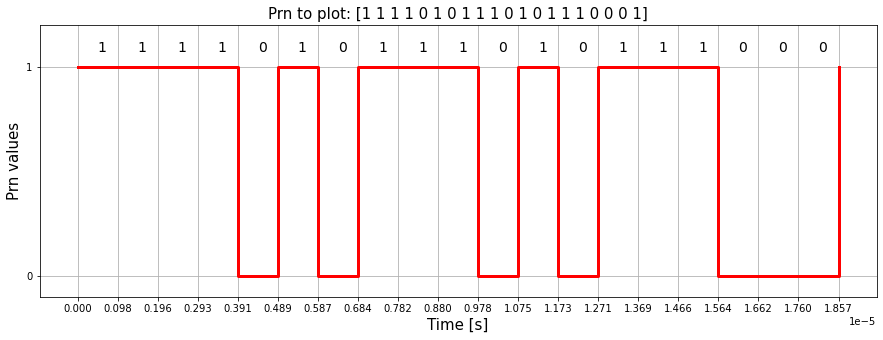

In [7]:
#this function plots the original PRNs

def plot_prn_zeros(N, prn):
    
    Rc = 1.023e06   # chip rate
    Tc = 1 / Rc     # chip period 
    
    t = np.arange(0, N*Tc, Tc)
    
    xticks = t
    yticks = [0, 1]
    centers = 0.5*(xticks[1:] + xticks[:-1]) 
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,1,1)
    ax.step(t, prn[0:N], where='post', color='red', lw=3)
    ax.set_xticks(t)
    ax.set_yticks(yticks)
    title = "Prn to plot: " + str(prn[0:N])
    ax.set_title(title, fontsize = 15)
    ax.set_ylim(-0.1,1.2)
    ax.set_xlabel("Time [s]", fontsize=15)
    ax.set_ylabel("Prn values", fontsize=15)
    ax.grid()
    for i,j in zip(centers, prn[0:N]):
        ax.text(i, 1.07, j, fontsize=14)   
        
plot_prn_zeros(20, e1bcopy['Binary'][0])

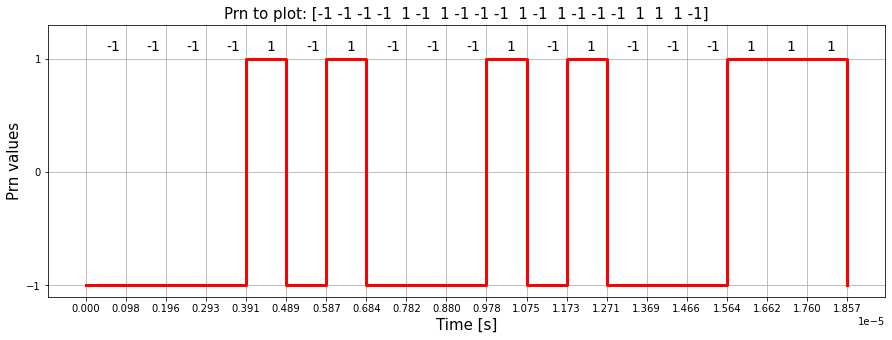

In [8]:
#this function plots the modified prns 

def plot_prn_modified(N, prn):
    
    Rc = 1.023e06   # chip rate
    Tc = 1 / Rc     # chip period 
    
    t = np.arange(0, N*Tc, Tc)
         
    xticks = t
    yticks = [-1, 0, 1]
    centers = 0.5*(xticks[1:] + xticks[:-1]) 
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,1,1)
    ax.step(t, prn[0:N], where='post', color='red', lw=3)
    ax.set_xticks(t)
    ax.set_yticks(yticks)
    title = "Prn to plot: " + str(prn[0:N])
    ax.set_title(title, fontsize=15)
    ax.set_ylim(-1.1,1.3)
    ax.set_xlabel("Time [s]", fontsize=15)
    ax.set_ylabel("Prn values", fontsize=15)
    ax.grid()
    for i,j in zip(centers, prn[0:N]):
        ax.text(i, 1.07, j, fontsize=14)   

plot_prn_modified(20, e1bmodifiedcopy['Modified'][0])

## BOC(1,1) MODULATION

The BOC(1,1) modulation is obtained by multiplying 4 components:
- the data message we need to transmit (given by a sequence of symbols with symbol period Tb);
- the PRN sequence we use to spread the data message (given by a sequence of chips with chip period Tc);
- a square wave subcarrier with period Tp = Tc (due to n = m = 1)
- a sinusoidal carrier 

In [9]:
#first we generate a random binary message of 80 bits (so it contains only zeros and ones)
message_len = 80
message = np.random.randint(0,2,message_len)
        
print("Data message:\n", message)

Data message:
 [0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1
 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0
 1 0 0 1 0 1]


Subcarrier length: 654720
[ 1 -1  1 ... -1  1 -1]


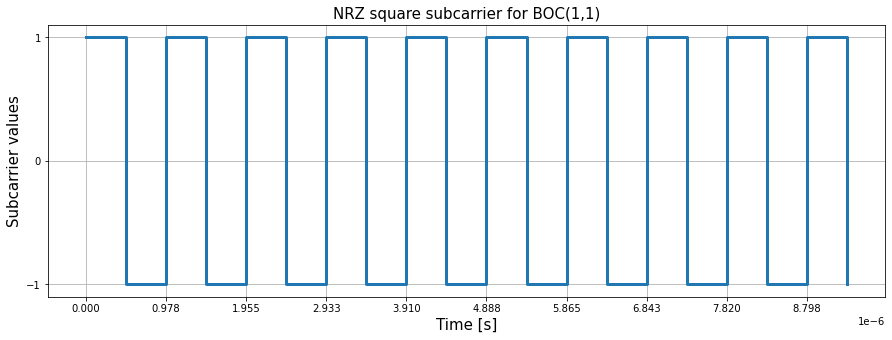

In [10]:
#Now we generate the BOC subcarrier, that is a square NRZ wave. The period of the waveform is given by Tc
#The needed length of the subcarrier is 654720. This will be clarified later, but basically the spreaded sequence
#is composed of 327360 symbols (data message is 80 symbols, and each symbol is spreaded with a PRN, that has 4092
#chips, so 80*4092 = 327360) and each symbol of the spreaded sequence is kept constant for 2 samples of the 
#subcarrier, therefore 327360*2 = 654720.

Rc = 1.023e06   # chip rate
Tc = 1 / Rc     # chip period 

rep = 2 
s = np.array([1, -1])
subcarrier = np.tile(s, 327360) # we repeat the values 1 and -1 for 327360 times in order to have an array of 654720 elements
                             

#now we plot the first 20 samples of the subcarrier
xticks = np.arange(0,10*Tc, Tc)
yticks = [-1, 0, 1]

t = np.arange(0, 10*Tc, Tc/2)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.step(t, subcarrier[0:20], where='post', lw=3)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_title('NRZ square subcarrier for BOC(1,1)', fontsize=15)
ax.set_xlabel('Time [s]', fontsize=15)
ax.set_ylabel('Subcarrier values', fontsize=15)
ax.grid()

print("Subcarrier length:", len(subcarrier))  
print(subcarrier)

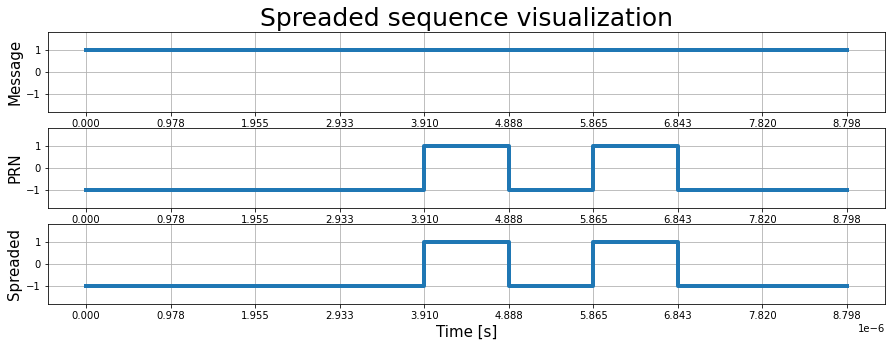

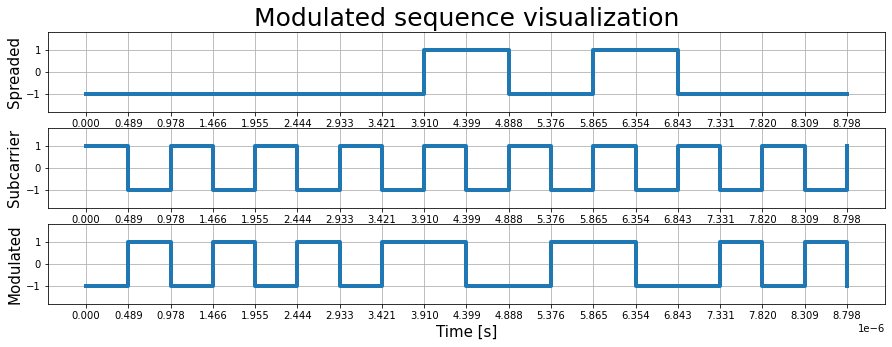


Modulated message:
 [-1.  1. -1. ... -1. -1.  1.]


In [11]:
#now we have the data message, the subcarrier and the prn can be retrieved from the dataframe
#we can create a function that does the modulation and (if flag = True) plots the signals

#Input: the data message (80 bits), the subcarrier (654720 samples) and the index of the PRN (4092 chips) to use,
#       that goes from 1 to 50 (while the prn index goes from 0 to 49) and a flag, to visualize it or not
#Output: the modulated signal

def boc(message, subcarrier, SV_index, flag):
    
    m = message #we use the variable m to avoid any modification of the original message
    
    #useful parameters
    Rb = 250   #The bit rate for GAL E1 is 250 symbols per second (equivalently, bits per second)
    Tb = 1 / Rb
    
    #first we convert the data message from bits to symbols
    for i in range(len(m)):
        if message[i] == 0:
            m[i] = 1
        elif message[i] == 1:
            m[i] = -1
    
    #we select the correct prn (based on the SV we have to communicate to)
    prn = e1bmodifiedcopy['Modified'][SV_index-1]
    
    #first the spreaded sequence is generated
    spreaded = np.zeros(327360)
    
    c = 0
    for i in range(len(m)):
        for j in range(len(prn)):
            spreaded[c] = m[i]*prn[j]
            c = c+1
    
    #so the spreaded sequence has been generated, now we apply the exact same procedure for the multiplication
    #by the subcarrier
    modulated = np.zeros(654720)

    c = 0
    for i in range(len(spreaded)):
        for j in range(2):
            modulated[c] = spreaded[i]*subcarrier[j]
            c = c+1

    #if the flag is set to true there is the visualization of the signals, otherwise no visualization
    #we plot the first 10 samples of the spreaded sequence 
    if(flag == True):
        fig = plt.figure(figsize=(15,5))
        fig.tight_layout()
        N = 10 
        t = np.arange(0,N*Tc, Tc)
        xticks = t
        
        #we plot the first sample of the data message (constant for the 10 represented chips)
        ax1 = fig.add_subplot(3,1,1)
        message_to_plot = np.tile(message[0], 10)
        ax1.step(t, message_to_plot, where='post', lw=4)
        ax1.set_xticks(xticks)
        ax1.set_yticks([-1,0,1])
        ax1.set_ylim(-1.8, 1.8)
        ax1.set_title("Spreaded sequence visualization", fontsize=25)
        ax1.set_xlabel("Time [s]", fontsize=15)
        ax1.set_ylabel("Message", fontsize=15)
        ax1.grid()

        #now we plot the first 10 values of the PRN
        ax2 = fig.add_subplot(3,1,2)
        prn_to_plot = prn[0:10]
        ax2.step(t, prn_to_plot, where='post', lw=4)
        ax2.set_xticks(xticks)
        ax2.set_ylim(-1.8, 1.8)
        ax2.set_yticks([-1,0,1])
        ax2.set_xlabel("Time [s]", fontsize=15)
        ax2.set_ylabel("PRN", fontsize=15)
        ax2.grid()

        #finally we plot the first 10 samples of the spreaded sequence, to verify that the multiplication was successful
        ax3 = fig.add_subplot(3,1,3)
        spreaded_to_plot = spreaded[0:10]
        ax3.step(t, spreaded_to_plot, where='post', lw=4)
        ax3.set_xticks(xticks)
        ax3.set_ylim(-1.8, 1.8)
        ax3.set_yticks([-1,0,1])
        ax3.set_xlabel("Time [s]", fontsize=15)
        ax3.set_ylabel("Spreaded", fontsize=15)
        ax3.grid()

        #now we create another figure for the modulated signal
        fig = plt.figure(figsize=(15,5))
        fig.tight_layout()
        
        ax1 = fig.add_subplot(3,1,1)
        N = 10 
        t = np.arange(0,N*Tc, Tc/2)
        t = t[:-1]
        
        #we start by plotting the spreaded sequence
        spreaded_to_plot = np.repeat(spreaded_to_plot[0:10], 2)
        xticks = t
        ax1.step(t, spreaded_to_plot[:-1], where='post', lw=4)
        ax1.set_xticks(xticks)
        ax1.set_yticks([-1,0,1])
        ax1.set_ylim(-1.8, 1.8)
        ax1.set_title("Modulated sequence visualization", fontsize=25)
        ax1.set_xlabel("Time [s]", fontsize=15)
        ax1.set_ylabel("Spreaded", fontsize=15)
        ax1.grid()

        #now we plot the subcarrier
        ax2 = fig.add_subplot(3,1,2)
        subcarrier_to_plot = subcarrier[0:19]
        ax2.step(t, subcarrier_to_plot, where='post', lw=4)
        ax2.set_xticks(xticks)
        ax2.set_ylim(-1.8, 1.8)
        ax2.set_yticks([-1,0,1])
        ax2.set_xlabel("Time [s]", fontsize=15)
        ax2.set_ylabel("Subcarrier", fontsize=15)
        ax2.grid()
        
        #finally we plot the first samples of the modulated signal
        ax3 = fig.add_subplot(3,1,3)
        modulated_to_plot = modulated[0:19]
        ax3.step(t, modulated_to_plot, where='post', lw=4)
        ax3.set_xticks(xticks)
        ax3.set_ylim(-1.8, 1.8)
        ax3.set_yticks([-1,0,1])
        ax3.set_xlabel("Time [s]", fontsize=15)
        ax3.set_ylabel("Modulated", fontsize=15)
        ax3.grid()        
        plt.show()
    return modulated

modulated = boc(message, subcarrier, 1, True)
print("\nModulated message:\n", modulated)

## I / Q SAMPLES

The modulated signal has been generated, and we can call it $s(t)$. The following step consists in generating the I/Q samples, that are simply obtained by multiplying the signal $s(t)$ by a cosine and a sine function:

$x_I(t) = s(t)\,\cos\,(2\,\pi\,f'\,t)$

$x_Q(t) = s(t)\,\sin\,(2\,\pi\,f'\,t)$

where $f'$ is a vector that contains all the Doppler frequencies computed during the process. This is because the I/Q samples are supposed to be generated in baseband, therefore there is no carrier frequency to consider in this case.

To generate the samples, we need of course to sample the signals $x_I(t)$ and $x_Q(t)$ and the sampling frequencies used in these cases are in the order of 4 or 5 MHz. A good choice might be to consider a sampling frequency $F_s = 4.092$ MHz (with a sampling period $T_s = \frac{1}{F_s} = 2.4438\,\cdot10^{-7} = \frac{T_c}{4}$ seconds.

This is a good choice because the signal $s\,(t)$ is composed of values spaced apart by $\frac{T_c}{2}$ seconds. By considering a sampling period of $\frac{T_c}{4}$ seconds we can sample the signal simply by considering two equal samples for each symbol in the signal $s(t)$.

Therefore, if for example we start from $s(t) = [-1, 1, -1 ...]$, after the process we are going to obtain $s(t) = [-1, -1, 1, 1, -1, -1 ...]$. Since, after the modulation, the length of $s(t)$ was 654720, after this process the length of $s(t)$ will be $654720\cdot2 = 1309440$ values.
Alternatively, we can also consider a sampling frequency $F_s = 8.184$ MHz (that refers to a sampling period $T_s = \frac{T_c}{8}$. In principle we can consider also bigger sampling frequencies, but energy and power consumption considerations must be also taken into account. Therefore we are going to use a sampling frequency $F_s = 4.092$ MHz (that correspond to $T_s = 2.4438\cdot10^{-7}$ seconds).

Regarding the Doppler frequencies, they are calculated by the orbit propagator group, and each value is referred to a new update of the satellite position. This is done with a sampling period that is way bigger than $\frac{T_c}{4}$, because the orbit parameters are typically updated less frequently. Therefore, in order to obtain a vector $f'$ with 1309440 values (to allow the multiplication of the cosine with $s(t))$, we need to interpolate the data provided by the other group.



### INTERPOLATION OF DOPPLER FREQUENCIES

In [12]:
###############################################
#                                             #
#  CODE FOR INTERPOLATION MUST BE ADDED HERE  #
#                                             #
###############################################

#For the moment, since we don't have the data from the other group, we can just simulate the vector f'
final_length = 1309440
f_prime = np.zeros(final_length)
f_max = 3000

f_prime[0] = np.random.uniform(-f_max, f_max, 1)

#with the following for loop we generate doppler frequencies between -3 KHz and 3 KHz. The absolute value of 
#the differential doppler frequency between two consecutive symbols is not greater than 0.3 Hz (from Mattia).
for i in range(1,final_length):
        f_prime[i] = np.random.uniform(f_prime[i-1] - 0.3, f_prime[i-1] + 0.3, 1)
    
print(f_prime[0:20])
print("\nLength of the vector f':", len(f_prime))

[2193.20395267 2193.22923828 2193.35849541 2193.0737953  2192.91572742
 2192.82060313 2193.08269178 2193.09180432 2193.23598714 2193.14601403
 2193.31347924 2193.41092795 2193.33125093 2193.21337542 2193.50119016
 2193.23414038 2193.15431608 2193.30687771 2193.2444146  2192.97416654]

Length of the vector f': 1309440


In [13]:
#so now we have the vector of Doppler frequencies, therefore we need to sample the signal s(t) (called "modulated"
#here) and to create the time vector t.
#As already said, each symbol of the vector s(t) has a duration of Tc / 2. Therefore if we use Ts = Tc / 4 we
#just need to repeat each symbol of s(t) two times. This can be easily done with the function np.repeat()

Fs = 4.092e06    #sampling frequency is 4.092 MHz
Ts = 1 / Fs      #sampling period, equal to Tc/4

#creation of the sampled signal
modulated_sampled = np.repeat(modulated, 2)
print("Before sampling:", modulated[0:9])
print("After sampling", modulated_sampled[0:18])
print("Length after sampling:", len(modulated_sampled))

#creation of the time vector
t_sampled = np.arange(0, final_length * Ts, Ts)   #1309440 values spaced apart by Tc / 4 seconds each
print("\nTime vector:", t_sampled)
print("Time vector length:", len(t_sampled))

Before sampling: [-1.  1. -1.  1. -1.  1. -1.  1.  1.]
After sampling [-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1.]
Length after sampling: 1309440

Time vector: [0.00000000e+00 2.44379277e-07 4.88758553e-07 ... 3.19999267e-01
 3.19999511e-01 3.19999756e-01]
Time vector length: 1309440


Now all the vectors have the right length, and we can obtain $x_I(t)$ and $x_Q(t)$, and we can also add the noise using the awgn function defined here.

In [14]:
#This function simulates the additive white gaussian noise channel. It takes as input the signal without the noise,
#the power of the noise in dB and a flag that allows the generation of the noise only if it is true.

def awgn(s, noise_power_dB, flag):
    length = len(s)
    if flag == True:
        noise = 10 ** (noise_power_dB/20) * np.random.randn(length)  
        #this returns gaussian samples drawn from the standard normal distribution, so with zero mean and unitary
        #variance. The zero mean is okay, but the variance of the noise should be equal to its power, so we need
        #to multiply by the standard deviation of the noise (that is the sqrt of the power, so the sqrt of
        #(10**noise_power_dB/10). That is why we put the multiplication factor there.
        s = s + noise
    return s


I: [-1.         -0.99999433  0.99997732  0.99994897 -0.9999093  -0.99985829
  0.99979589  0.99972219 -0.9996371  -0.99954075  0.99943295  0.99931383
 -0.99918347 -0.99904184  0.9988885   0.99872439  0.99854878  0.99836154
 -0.99816327 -0.9979541 ]


After noise addition on I:
 [-0.92252876 -1.00743215  1.01174658  0.97823433 -1.02006225 -1.02078288
  0.96360498  0.97854584 -0.97155411 -0.93216065  0.99839288  1.04387013
 -0.98238712 -0.97083524  0.96233263  1.05833947  1.04169592  1.00035935
 -0.98298782 -0.91142505]

Q: [-0.         -0.00336765  0.00673567  0.01010209 -0.01346831 -0.01683437
  0.02020324  0.02356996 -0.02693811 -0.03030315  0.03367153  0.03703886
 -0.0404028  -0.04376528  0.04713562  0.05049354  0.05385466  0.05722098
 -0.06058119 -0.06393447]


After noise addition on Q:
 [ 0.00372923 -0.00827024  0.00708975  0.01114943 -0.01430759 -0.01687365
  0.02001192  0.01874911 -0.02760078 -0.03625143  0.03439369  0.03440963
 -0.03961973 -0.04417491  0.04391794  0.05111717  0

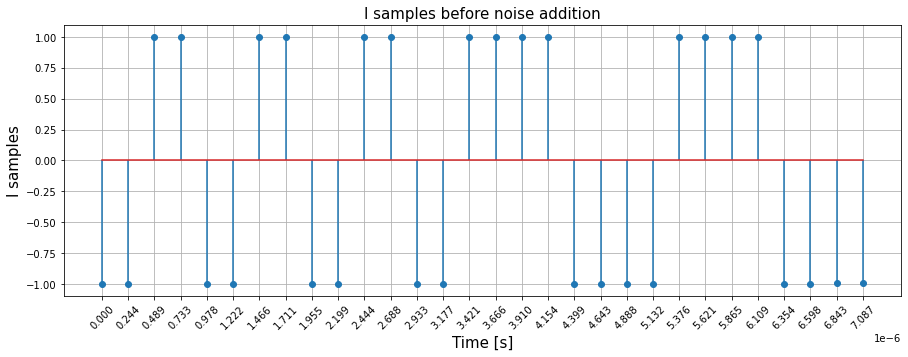

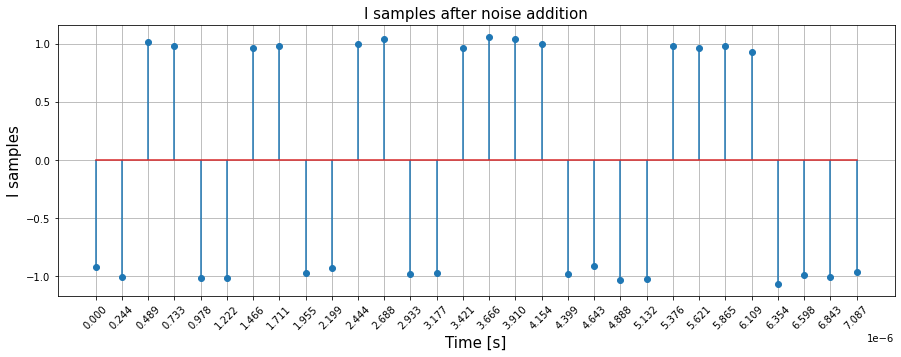

In [15]:
I = modulated_sampled*np.cos(2*pi*f_prime*t_sampled) 
print("\nI:", I[0:20])

#addition of noise 
I_noise = awgn(I, -30, True)
print("\n\nAfter noise addition on I:\n", I_noise[0:20])

Q = modulated_sampled*np.sin(2*pi*f_prime*t_sampled)
print("\nQ:", Q[0:20])

#addition of noise (noise power = -50 dB): THIS VALUE MUST BE CHECKED, NO IDEA ABOUT NOISE POWER TYPICAL VALUES
Q_noise = awgn(Q, -50, True)
print("\n\nAfter noise addition on Q:\n", Q_noise[0:20])

#some plots (first N samples)
N = 30

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
xticks = t_sampled[0:N]
ax.stem(t_sampled[0:N], I[0:N])
ax.set_xticks(xticks)
plt.xticks(rotation=45)
ax.set_title("I samples before noise addition", fontsize=15)
ax.set_xlabel("Time [s]", fontsize=15)
ax.set_ylabel("I samples", fontsize=15)
ax.grid()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
xticks = t_sampled[0:N]
ax.stem(t_sampled[0:N], I_noise[0:N])
ax.set_xticks(xticks)
plt.xticks(rotation=45)
ax.set_title("I samples after noise addition", fontsize=15)
ax.set_xlabel("Time [s]", fontsize=15)
ax.set_ylabel("I samples", fontsize=15)
ax.grid()